In [1]:
# to import from parent directory
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from utils import get_lags, remove_nan
from sklearn.decomposition import PCA
# from statsmodels.multivariate.pca import PCA
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error

In [3]:
full = pd.read_csv('../normalised_growth.csv', index_col=0, header=[0] ,parse_dates=True)
full.head()

,CPIAUCSL,FEDFUNDS,HOUST,INDPRO,INTDSRUSM193N,ISRATIO,M2SL,MTSDS133FMS,PAYEMS,PCE,...,CIVPART,GS20,GS3,IRLTLT01USM156N,M1SL,MCOILWTICO,PPIACO,TCU,TOTALSA,PMI
1914-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.635906,NaN,NaN,NaN
1914-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.543396,NaN,NaN,NaN
1914-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.638258,NaN,NaN,NaN
1914-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.638258,NaN,NaN,NaN
1914-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.640650,NaN,NaN,NaN


In [4]:
# start from 1960
full.drop(columns=['A191RL1Q225SBEA'], inplace=True)
full = full.loc["1960-01-01":"2019-01-01"]
full = remove_nan(full)
print(full.shape)

INTDSRUSM193N
ISRATIO
MTSDS133FMS
T10Y2YM
USSLIND
GFDEGDQ188S
GS20
MCOILWTICO
TCU
TOTALSA
(709, 21)


In [5]:
length = len(full)
val_start = round(length * 0.8) # not needed
test_start = round(length * 0.9)    

In [6]:
core_series = ["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"]

core = full[core_series]
other = full.drop(columns=core_series)

print(core.shape)

(709, 3)


In [7]:
pc = PCA()
pc.fit(other)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'Eigenvalues')

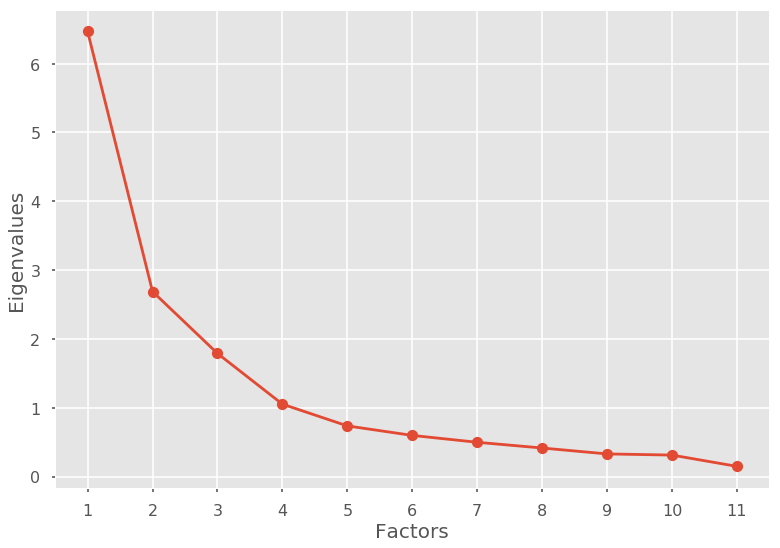

In [8]:
# scree plot

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

plt.plot([i for i in range(1, 12)], pc.explained_variance_[:11], marker = "o")

plt.xticks([i for i in range(1, 12)])

# plt.legend((), facecolor="white")
plt.xlabel("Factors", fontsize=20)
plt.ylabel("Eigenvalues", fontsize=20)
# plt.savefig('../Figs/scree.png', bbox_inches='tight')

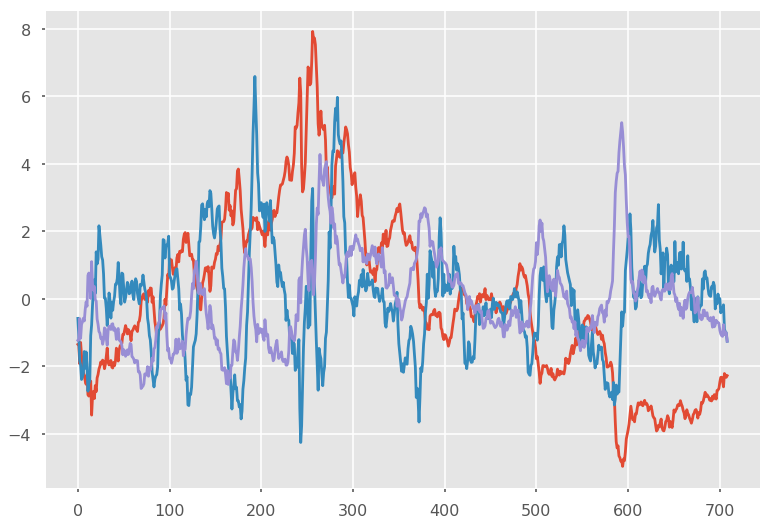

In [9]:
# first three factors
plt.plot(pc.transform(other)[:,:3])

In [11]:
pc.explained_variance_ratio_[0] + pc.explained_variance_ratio_[1]

0.6039260436245935

In [15]:
comps = pd.DataFrame(pc.transform(other)[:,:2], index=core.index, columns=["comp_00", "comp_01"])
print(comps.shape)

(709, 2)


In [17]:
var_series = pd.concat([core, comps], axis=1)
var_series.shape

(709, 5)

In [18]:
train = var_series.iloc[:test_start-1]
test = var_series.iloc[test_start:]

print(train.shape)

(637, 5)


In [19]:
model = VAR(train, freq='MS')
model.select_order(15).summary()

,AIC,BIC,FPE,HQIC
0,0.3498,0.3854,1.419,0.3636
1,-17.53,-17.32,2.432e-08,-17.45
2,-18.58,-18.19*,8.531e-09,-18.43*
3,-18.63,-18.06,8.090e-09,-18.41
4,-18.67,-17.92,7.827e-09,-18.38
5,-18.75,-17.83,7.177e-09,-18.39
6,-18.71,-17.61,7.476e-09,-18.28
7,-18.70,-17.41,7.594e-09,-18.20
8,-18.68,-17.22,7.695e-09,-18.12
9,-18.67,-17.03,7.775e-09,-18.04


In [20]:
results = model.fit(maxlags=15, ic='bic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 31, Aug, 2019
Time:                     23:02:12
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -18.0735
Nobs:                     635.000    HQIC:                  -18.3094
Log likelihood:           1410.67    FPE:                9.62226e-09
AIC:                     -18.4592    Det(Omega_mle):     8.83046e-09
--------------------------------------------------------------------
Results for equation CPIAUCSL
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.003265         0.004986            0.655           0.513
L1.CPIAUCSL                1.305148         0.038510           33.891           0.000
L1.A191RO1Q156NBEA         0.000171  

In [21]:
from utils import plot_var_forc

In [22]:
def plot_forecast_custom(results, steps, previous = 20, alpha=0.05, plot_stderr=True):
    mid, lower, upper = results.forecast_interval(results.y, steps=12, alpha=0.05)
    fig = plot_var_forc(results.y[-previous:], mid, lower, upper, names=results.names, plot_stderr=plot_stderr)
    return fig


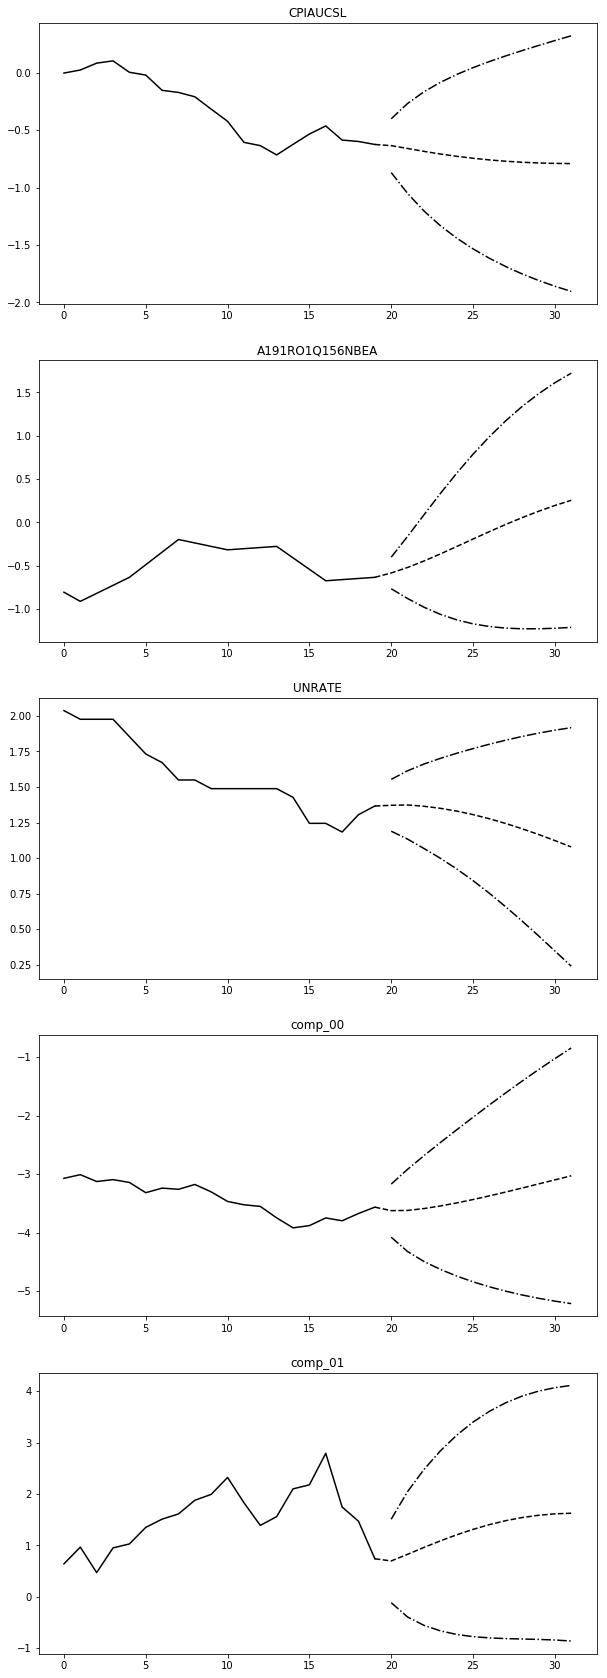

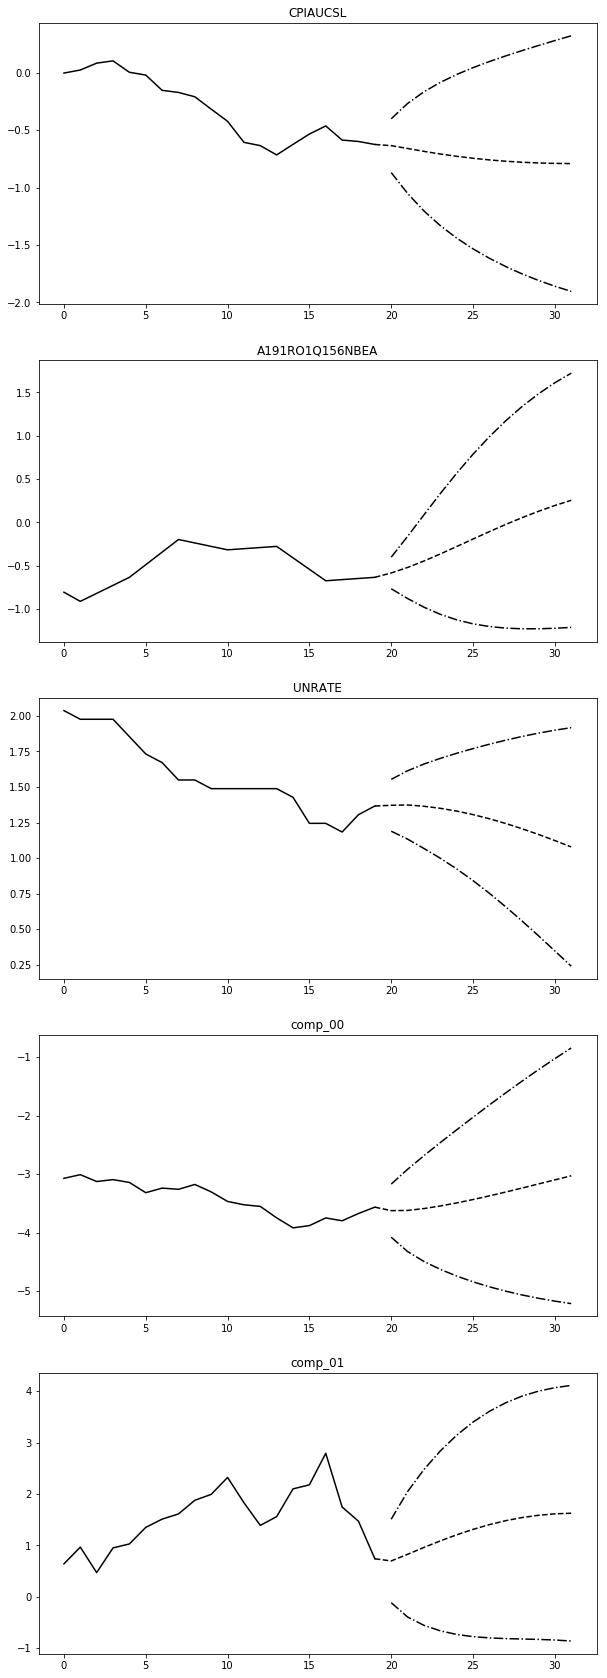

In [23]:
plot_forecast_custom(results, steps = 3)